In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from tqdm import tqdm
from glob import glob
import os, sys
import numpy as np
from configs import *
from utils import *
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from dataset import *
import torch.optim as optim
torch.manual_seed(0)
np.random.seed(0)

In [3]:
ESIZE = 64
EPS = 30
BSIZE = 32
STOPS = 3
LAG = 12
HSIZE = 256
SROUTE = SAMPLE_ROUTES[0]
SIND = 30
LR = 0.001
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [4]:
dset = SingleStop(SROUTE, SIND, 'train', BSIZE, stops=STOPS, lag=LAG).generator()
evalset = SingleStop(SROUTE, SIND, 'test', BSIZE, stops=STOPS, lag=LAG).generator()

Locals dataset: train
 [*] Loaded routes: 1 (0.22s)
 [*] Has trainable inds: 262262
 [*] Subset train: 212106
 [*] Subset in Stop-30: 6079
Locals dataset: test
 [*] Loaded routes: 1 (0.24s)
 [*] Has trainable inds: 262262
 [*] Subset test: 50156
 [*] Subset in Stop-30: 1549


In [5]:
kernels = None
upops = None
opt = None
criterion = nn.MSELoss().to(device)

In [8]:
from models.Kernel import *

def evaluate(batch, train=True):
    gl = []
    _tys, tys = [], []
    for ti, graph_t in enumerate(batch[1:]):
        isFirst = ti == 0
        isNotLast = not (ti == len(batch)-2)

        for iter in range(1):
            message(kernels, states, iteration=iter) # spatial msgs
            update(upops, states) # spatial update
#             timestep(tops, states)

        # gather comparisons against t+1 graph values
        _ys, ys = zip(*gather_predictions(graph_t, states))
        _tys.append(_ys)
        tys.append(ys)

        _yl, yl = torch.stack(_ys, dim=1).squeeze(2), torch.stack(ys, dim=1).squeeze(2)
        if train:
            opt.zero_grad()
            loss = criterion(yl, _yl)
            loss.backward(retain_graph=True)
            opt.step()
            loss = loss.item()
        else:
            loss = criterion(yl, _yl)
            loss = loss.item()
        gl.append(loss)
        reassign_v(states, graph_t)
            
    return  _tys, tys, np.mean(gl)

def init(states):
    global kernels, upops, opt
    if kernels is None:
        kernels, kps = inst_tree(
            lambda node: Kernel(insize=1 + len(node.ns), hsize=HSIZE).to(device), 
            states, device=device)
        print('Params: %d' % len(kps))
        print('Kernels: %d' % count_rec(kernels, lambda node: node['ns']))
        upops, ups = inst_tree(
            lambda _: Update(hsize=HSIZE).to(device), 
            states, device=device)
#             tops, tps = inst_tree(
#                 lambda _: TimeStep(hsize=HSIZE).to(device), 
#                 states, device=device)
        opt = optim.SGD(kps + ups, lr=LR)
    
losses = []
for ei in range(EPS):
    els = []
    for bi, batch in enumerate(evalset):
        batch = routeToGraph(
            batch, 
            zero=lambda: torch.zeros(BSIZE, HSIZE), 
            device=device)
        states = batch[0] # will be used to hold iterated values
        init(states)
        _, _, loss = evaluate(batch, train=False)
        els.append(loss)
    print('Eval loss: %.4f' % np.mean(els))
    
    for bi, batch in enumerate(dset):
        batch = routeToGraph(
            batch, 
            zero=lambda: torch.zeros(BSIZE, HSIZE), 
            device=device)

        states = batch[0] # will be used to hold iterated values
        init(states)
        _tys, tys, loss = evaluate(batch, train=True)
            
        ytrue = torch.stack([torch.stack(_ys, dim=1).squeeze(2) for _ys in _tys], dim=2)
        ypred = torch.stack([torch.stack(ys, dim=1).squeeze(2) for ys in tys], dim=2)
        
        sys.stdout.write('[E%d:%d - B%d:%d] L%.2f    \r' % (
            ei + 1, EPS,
            bi, len(dset), 
            loss))
        losses.append(loss)
    sys.stdout.write('\n')
    sys.stdout.flush()

Params: 40
Kernels: 2
Eval loss: 16.9018
[E1:30 - B188:189] L8.79    
Eval loss: 3.3197
[E2:30 - B188:189] L1.61    
Eval loss: 3.3316
[E3:30 - B188:189] L2.53    
Eval loss: 3.3288
[E4:30 - B188:189] L2.55    
Eval loss: 3.3018
[E5:30 - B188:189] L2.20    
Eval loss: 3.2895
[E6:30 - B188:189] L2.64    
Eval loss: 3.2966
[E7:30 - B188:189] L1.98    
Eval loss: 3.3234
[E8:30 - B188:189] L1.93    
Eval loss: 3.2876
[E9:30 - B188:189] L5.91    
Eval loss: 3.2801
[E10:30 - B188:189] L2.74    
Eval loss: 3.2883
[E11:30 - B188:189] L4.20    
Eval loss: 3.2830
[E12:30 - B188:189] L1.85    


Process Process-158:
Process Process-161:
Process Process-162:
Process Process-159:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process Process-160:
Process Process-157:
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 104, in get
    if timeout < 0 or not self._poll(timeout):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):


KeyboardInterrupt: 

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 104, in get
    if timeout < 0 or not self._poll(timeout):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 24

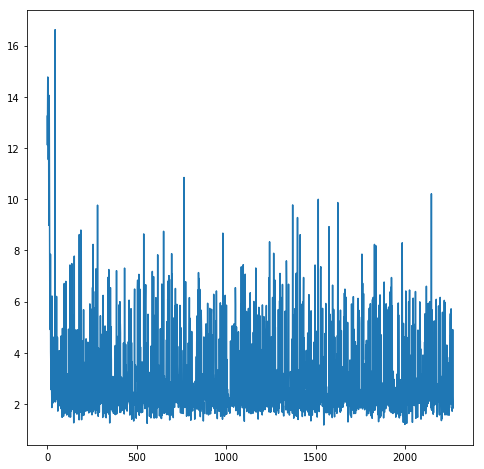

In [9]:
plt.figure(figsize=(8, 8))
plt.plot(losses)
plt.show(); plt.close()

In [10]:
print(_tys[0][0][0])

tensor([2.1136], device='cuda:1')


In [11]:
yt = tonpy(ytrue)
yp = tonpy(ypred)
print(yt.shape)

(32, 2, 11)


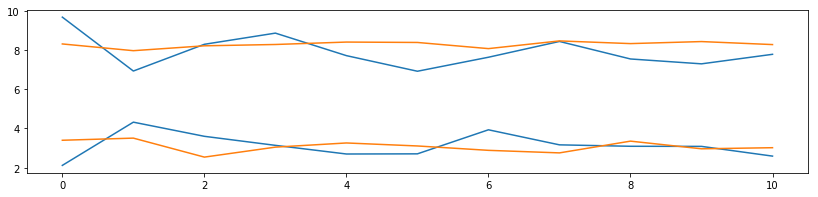

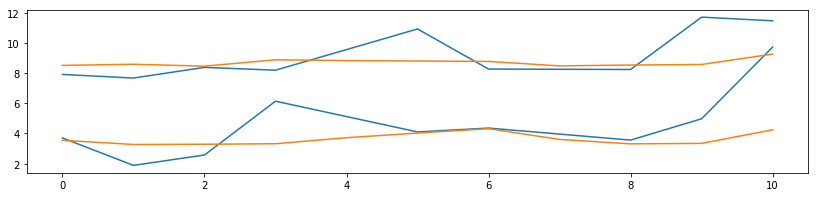

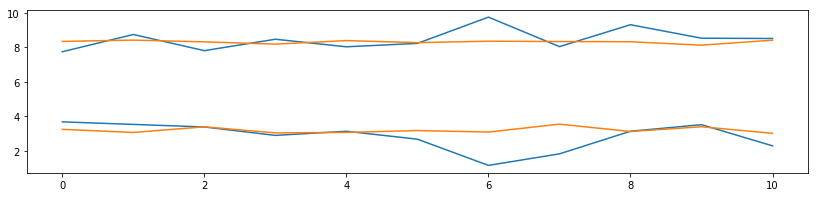

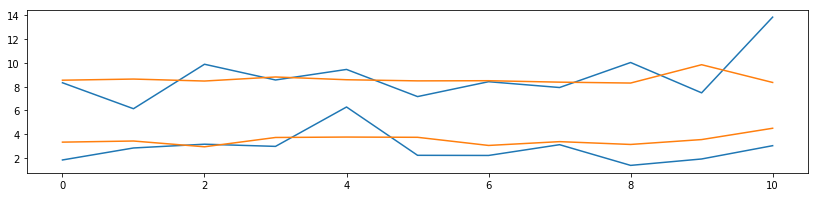

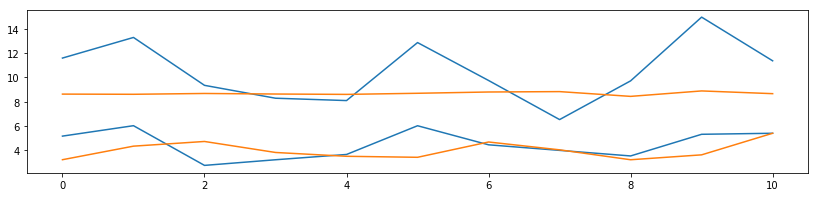

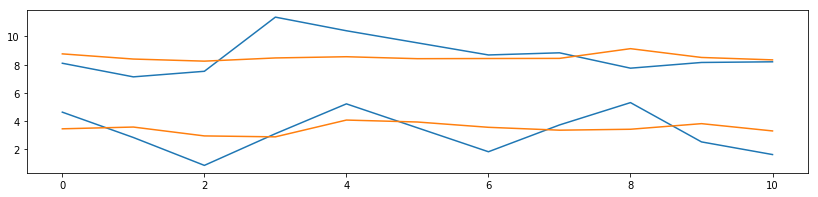

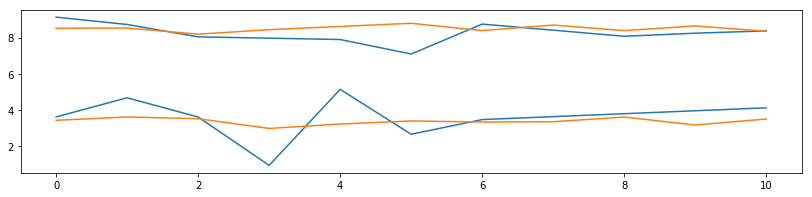

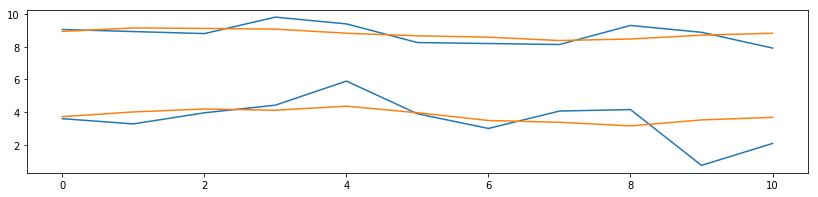

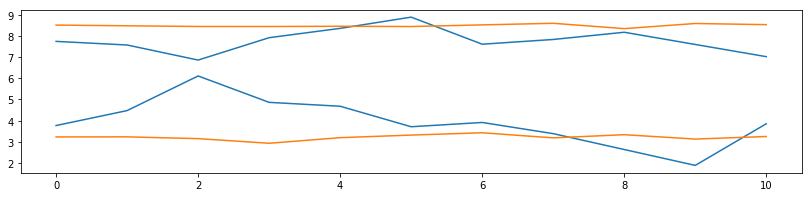

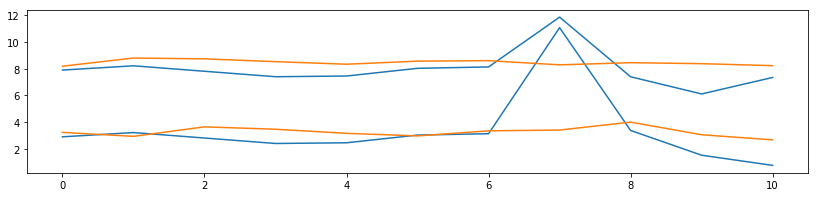

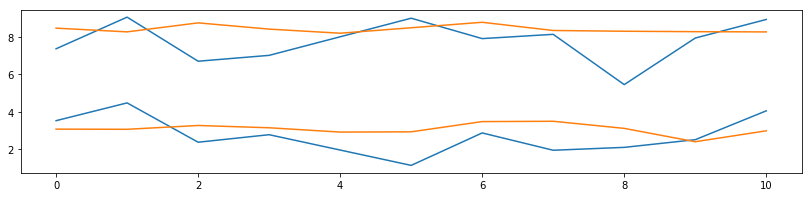

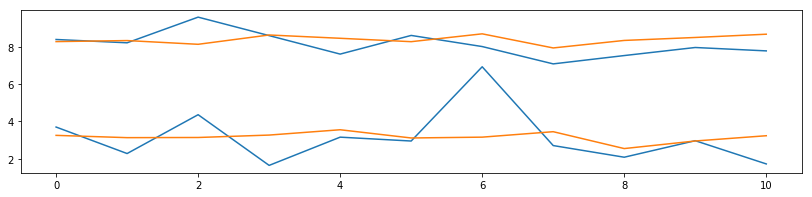

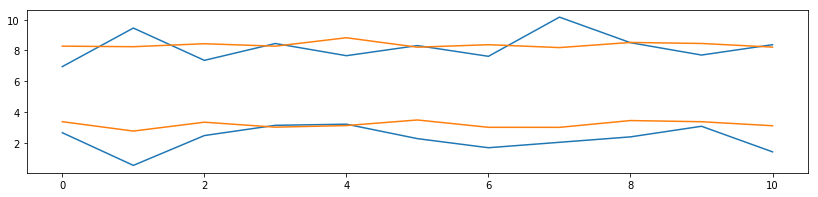

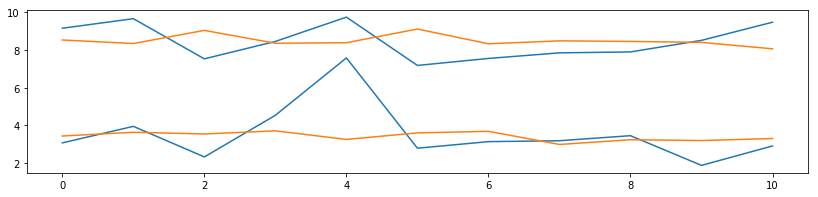

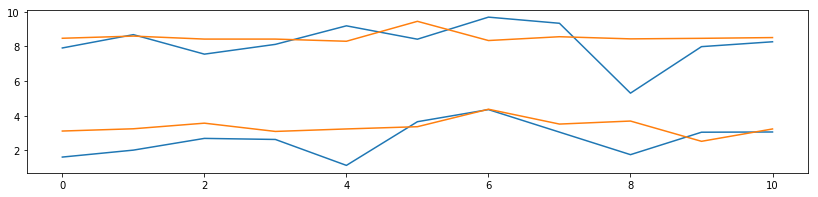

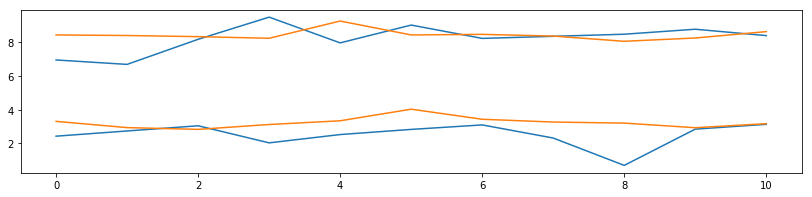

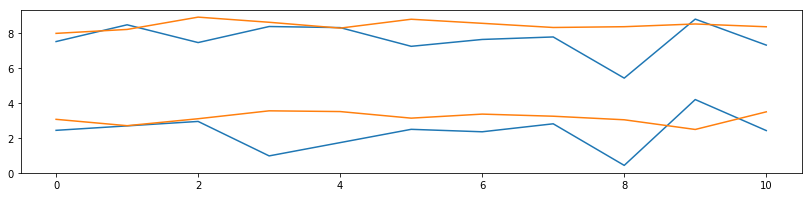

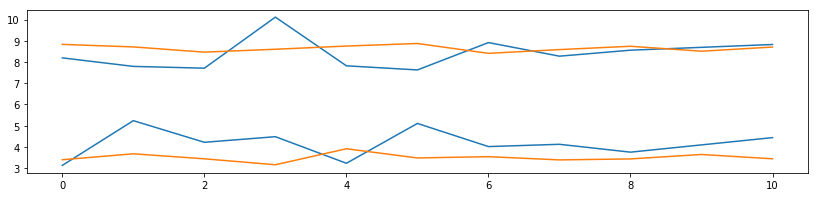

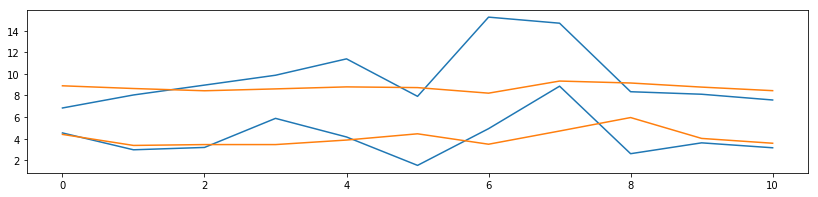

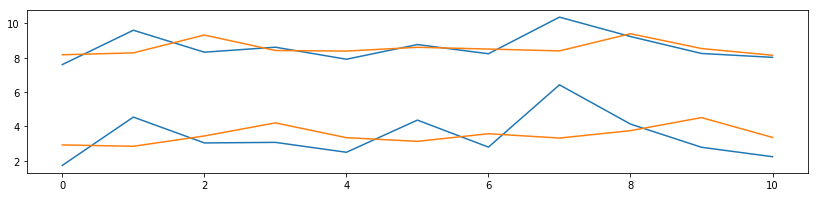

In [12]:
for bat in range(20):
    plt.figure(figsize=(14, 3))
    for si in range(STOPS-1):
        off = si * 5
        plt.plot(yt[bat][si] + off, color='C0')
        plt.plot(yp[bat][si] + off, color='C1')
#     plt.ylim(0, 10)
    plt.show(); plt.close()